# Classification using random and Nyström features.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of random and Nystöm features with linear SVMs to carry out non-linear classification.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import kernel_approximation as ka

from sklearn import svm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import RBFSampler
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import Matern
import warnings

seed = 123
np.random.seed(seed)

In [2]:
"""
# A simple 2 D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""
# A not so simple 2 D problem
noise = 0.3

# Training set 
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions

grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)

grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

# Plot the decision regions 
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)


    plt.imshow(Z, interpolation='nearest',
    extent=(grid_x1.min(), grid_x1.max(), grid_x2.min(), grid_x2.max()), aspect='auto',
    origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0], linewidths=2,
    linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
    edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1), np.min(grid_x2), np.max(grid_x2)])
    plt.show()

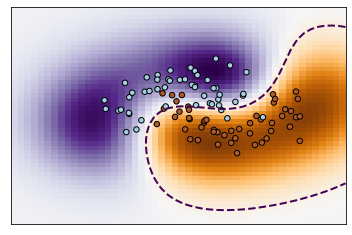

In [3]:
# Nonlinear SVM 

gamma = 0.5
sigma = np.sqrt(1.0 / 2.0 / gamma)

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)

clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

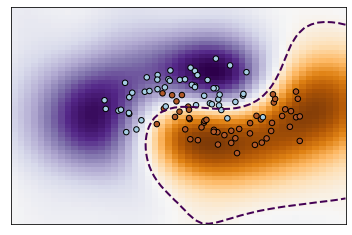

In [4]:
# RBF Fourier random features (sklearn)

n_random_features = 10000

rbf_sampler = RBFSampler(gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')

clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

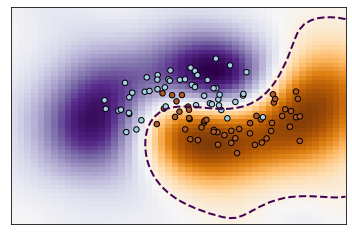

In [5]:
# RBF Fourier random features (our implementation)

rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma,n_random_features)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)


plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

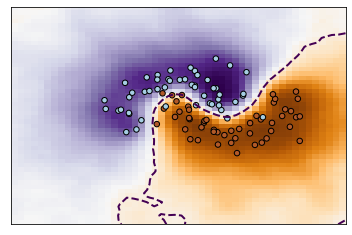

In [6]:
# Matérn Fourier random features (our implementation)
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu, n_random_features)    
random_features = matern_sampler.fit_transform(X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

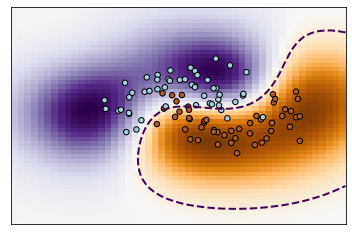

In [7]:
# Nystroem features (our implementation)

# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(kernel,n_nystroem_features)
nystroem_features = nystroem_sampler.fit_transform(X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Exercises

1. Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers consideres in this example using CV on the training set. Compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 

References:
https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py



In [8]:
min_max_scaler = MinMaxScaler((-1,1))
X_minmax = min_max_scaler.fit_transform(X)
X_test_minmax = min_max_scaler.transform(X_test)

In [9]:
# declare classifiers (name,pipeline)
classifiers = [
    ('Nonlinear SVM', 
         Pipeline( [('svc_rbf',
                     svm.SVC(kernel='rbf'))]) ),
    
    ('RBF Fourier RF (sklearn)',
         Pipeline([('rbf_sklearn', RBFSampler()),
                   ('svc_linear', svm.SVC(kernel='linear'))])),
    
    ('RBF Fourier RF (ours)',
         Pipeline([('rbf_ours', ka.RandomFeaturesSamplerRBF()),
                   ('svc_linear_fourier', svm.SVC(kernel='linear'))])),
    
    ('Matérn Fourier RF (ours)',
         Pipeline([('matern_ours', ka.RandomFeaturesSamplerMatern()), 
                   ('svc_linear', svm.SVC(kernel='linear'))])),
    
    ('Nystroem features (ours)', 
         Pipeline([('nystroem_rbf', ka.NystroemFeaturesSampler()),
                   ('svc_linear', svm.SVC(kernel='linear'))])),
    
    ('Nystroem features (our implementation) with Matern Kernel (Sklearn)', 
         Pipeline([('nystroem_matern', ka.NystroemFeaturesSampler(kernel = Matern())),
                   ('svc_linear', svm.SVC(kernel='linear'))]))
]

# Pre-define param vectors to reuse
gammas = np.logspace(-4,4,15)
sigmas = np.sqrt(1.0 / 2.0 / gammas)
nus = np.linspace(0.5,3,6)
n_features = [10,20,30,40,50,
              60,70,80,90,100,
              150,200,300,500]

param_search_space = [
    # Nonlinear SVM
    {'svc_rbf__gamma': gammas},
    
    # RBF Fourier RF + SVC Sklearn
    {'rbf_sklearn__gamma': gammas,
     'rbf_sklearn__n_components': n_features},
    
    # RBF RF (ours) + SVC sklearn
    {'rbf_ours__sigma': sigmas,
     'rbf_ours__n_random_features': n_features},
    
    # Matern Fouriers RF (ours) + SVC Sklearn
    {'matern_ours__scale': sigmas,
     'matern_ours__nu': nus,
     'matern_ours__n_random_features': n_features},
    
    # Nystroem features (ours) + SVC Sklearn
    {'nystroem_rbf__n_random_features': n_features,
     'nystroem_rbf__kernel__length_scale': sigmas},
    
    # Nystroem features (ours) + SVC Sklearn
    {'nystroem_matern__n_random_features': n_features,
     'nystroem_matern__kernel__length_scale': sigmas,
     'nystroem_matern__kernel__nu': nus}
]


for (name,model), param_space in zip(classifiers, param_search_space):
    print(name)
    print()
    
    clf = GridSearchCV(
        model,
        param_space
    )
    
     # Find best classifier
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        clf.fit(X_minmax, y)
    
    print("Best parameters set found on development set:")
    for param in clf.best_params_.keys():
        param_name = param.split("__")[-1]
        print("\t - {} : {}".format(param_name, clf.best_params_[param]))

    
    # Predict on test and get score
    test_score = clf.score(X_test_minmax, y_test)
    
    print("Scores of best parameters")
    print("\t Train: " + str(clf.best_score_))
    print("\t Test:  " + str(test_score))
    print("-------------------")

Nonlinear SVM

Best parameters set found on development set:
	 - gamma : 13.89495494373136
Scores of best parameters
	 Train: 0.9400000000000001
	 Test:  0.906
-------------------
RBF Fourier RF (sklearn)

Best parameters set found on development set:
	 - gamma : 13.89495494373136
	 - n_components : 500
Scores of best parameters
	 Train: 0.95
	 Test:  0.914
-------------------
RBF Fourier RF (ours)

Best parameters set found on development set:
	 - n_random_features : 300
	 - sigma : 5.0889461970191885
Scores of best parameters
	 Train: 0.95
	 Test:  0.911
-------------------
Matérn Fourier RF (ours)

Best parameters set found on development set:
	 - n_random_features : 300
	 - nu : 2.0
	 - scale : 5.0889461970191885
Scores of best parameters
	 Train: 0.95
	 Test:  0.911
-------------------
Nystroem features (ours)

Best parameters set found on development set:
	 - length_scale : 0.18969523887029333
	 - n_random_features : 50
Scores of best parameters
	 Train: 0.9400000000000001
	 Test

The model which best performed was the RBF Fourier RF by Sklearn, scoring $0.914$ in the test set with parameters $(\gamma \approx 13.89, \ \text{n_components}=500).$

We appretiate that the results obtained by the methods that extract Nystroem features perform **very equally** to the methods that use the complete Kernel Matrix. Also, the following must be remarked:

- The same $\gamma$ parameter is found for both the non-linear SVC and the RBF sampler.
- The $\sigma$ and the scale parameter matches netween the implementation of Fourier Random Features and Matern Fourier Random Features.
- Additionaly, the same $\nu$ parameter is found in both searches using the Matern Kernel.

One question remains: a direct comparisson between our RBF Fourier RF kernel and Sklearn's best parameters differs in the gamma and the sigma values. In order to check whether our implementation of the RBF Fourier RF kernel is correct we need the biyection betwenn $\gamma$ and $\sigma$ and make sure we obtain equivalent results.

Looking at the given code we see that our random vector $w$ is sampled from a multivariate normal distribution:

$$
    w \sim N(0, \sigma^2 \; \mathcal I)
$$

Thus, its *pdf* will be:

$$
    p(w) = |2\pi\sigma^2 \mathcal I|^{-1/2} \; \text{exp}\left( -\frac{1}{2\sigma^2} w^Tw \right)
    = (2\pi\sigma^2)^{-D/2} \; \text{exp}\left( -\frac{1}{2\sigma^2} w^Tw \right)
$$

Following Bochner’s theorem, let us compute the Fourier transform of the measure associated to $w$ to find the respective kernel. Let $\delta = x - y$, then:

\begin{align*}
    k(\delta) & = \int_{\mathcal R^D} p(w) \; \text{exp}( i w^T \delta ) \; \text dw \\
    & = \left(2\pi\sigma^2\right)^{-D/2} \int_{\mathcal R^D} \text{exp}\left( -\frac{1}{2\sigma^2} w^Tw \right) \; \text{exp}( i w^T \delta ) \; \text dw \\
    & = \left(2\pi\sigma^2\right)^{-D/2} \int_{\mathcal R^D} \text{exp}\left( -\frac{1}{2\sigma^2} w^Tw + i w^T \delta \right) \; \text dw \\
    & \substack{(1) \\ =} \left(2\pi\sigma^2\right)^{-D/2} \int_{\mathcal R^D} \text{exp}\left(
        -\frac{1}{2} \left( \frac{1}{\sigma^2}w^Tw -2iw^T\delta - \sigma^2\delta^T\delta \right)
        -\frac{\sigma^2}{2}\delta^T\delta \right) \; \text dw \\
    & = \left(2\pi\sigma^2\right)^{-D/2} 
        \text{exp} \left(-\frac{\sigma^2}{2}\delta^T\delta \right)
        \int_{\mathcal R^D} \text{exp}\left(
        -\frac{1}{2} \left( \frac{1}{\sigma^2}w^Tw -2iw^T\delta - \sigma^2\delta^T\delta \right)\right) \; \text dw \\
    & = \left(2\pi\sigma^2\right)^{-D/2} 
        \text{exp} \left(-\frac{\sigma^2}{2}\delta^T\delta \right)
        \int_{\mathcal R^D} \text{exp}\left(
        -\frac{1}{2} \left( \frac{1}{\sigma}w -i\sigma\delta \right)^T
                     \left( \frac{1}{\sigma}w -i\sigma\delta \right) \right) \; \text dw \\
    & = \left(2\pi\sigma^2\right)^{-D/2} 
        \text{exp} \left(-\frac{\sigma^2}{2}\delta^T\delta \right)
        \int_{\mathcal R^D} \text{exp}\left(
        -\frac{1}{2\sigma^2} \left( w -i\sigma^2\delta \right)^T
                             \left( w -i\sigma^2\delta \right) \right) \; \text dw \\
\end{align*}

where in $(1)$ we added and substracted $\frac{\sigma^2}{2}\delta^T\delta$ and extracted $-\frac{1}{2}$ as common factor. At this point we realize that if $X \sim N(i\delta\sigma^2, \sigma^2 \; \mathcal I)$, then its *pdf* integrates $1$:

\begin{align*}
    1 & = \left(2\pi\sigma^2\right)^{-D/2} \; \int_{\mathcal R^D} \text{exp}\left(
        -\frac{1}{2\sigma^2} \left( x -i\sigma^2\delta \right)^T
                             \left( x -i\sigma^2\delta \right) \right) \; \text dx \implies \\
    \left(2\pi\sigma^2\right)^{D/2} & = \int_{\mathcal R^D} \text{exp}\left(
        -\frac{1}{2\sigma^2} \left( x -i\sigma^2\delta \right)^T
                             \left( x -i\sigma^2\delta \right) \right) \; \text dx
\end{align*}

Using the previous equality we may finish our development:

\begin{align*}
    k(\delta) & = \left(2\pi\sigma^2\right)^{-D/2} 
        \text{exp} \left(-\frac{\sigma^2}{2}\delta^T\delta \right)
        \int_{\mathcal R^D} \text{exp}\left(
        -\frac{1}{2\sigma^2} \left( w -i\sigma^2\delta \right)^T
                             \left( w -i\sigma^2\delta \right) \right) \; \text dw \\
    & = \left(2\pi\sigma^2\right)^{-D/2} 
        \text{exp} \left(-\frac{\sigma^2}{2}\delta^T\delta \right)
        \left(2\pi\sigma^2\right)^{D/2}  \\
    & = \text{exp} \left(-\frac{\sigma^2}{2}\delta^T\delta \right) \\
\end{align*}

Obtaining the RBF kernel with $\gamma = \frac{\sigma^2}{2}$. Does this matches our empirical results? We obtained:

\begin{align*}
    \gamma & \approx 13.89 \\
    \sigma & \approx 5.09 \\
    \frac{\sigma^2}{2} & \approx 12.95 \\
\end{align*}

which results in almost a whole unit of difference which may be attributed to numerical errors.